In [1]:
#######################     LIBRARIES     ##########################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from multifidelity_NN_functions import compute_randomized_SVD, sliding_windows, getOpti, reshape_lstm, create_model, train_model, load_model, save_model, load_reaction_diffusion
import pickle
import os
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import model_from_json
import mat73
import scipy.io
from scipy.interpolate import griddata

seed = 7

train = False
scaling = True
save = False
small_data = True

path = './data/reaction_diffusion/'

In [2]:
#########################   DATA     ##########################
#Time
tlf_0 = 0.
thf_0 = 0.
Tlf = 80. 
Thf = 40.
dt = 0.05

#Parameters
mu_0 = 0.5
mu_1 = 1.5

N_mu_train = 10
mu_train = np.linspace(mu_0, mu_1, N_mu_train, endpoint = True)

if small_data:
    N_mu_test = 2
    mu_test = np.array([0.875, 1.375])
else:
    N_mu_test = 25
    mu_test = np.linspace(mu_0, mu_1, N_mu_test, endpoint = True)
    
#Load data train
u_lf, x_LF, t_lf = load_reaction_diffusion(mu_train, 'LF', path = path + 'train/')
u_hf, x_HF, t_hf = load_reaction_diffusion(mu_train, 'HF', path = path + 'train/')

Nx_lf, Ny_lf, Nt_lf_train, N_mu_train = u_lf.shape
Nx_hf, Ny_hf, Nt_hf_train, N_mu_train = u_hf.shape

#Load data test
u_lf_test, _, t_lf_test = load_reaction_diffusion(mu_test, 'LF', path = path + 'test/')
u_hf_test, _, t_hf_test = load_reaction_diffusion(mu_test, 'HF', path = path + 'test/', splitted = True)

Nx_lf, Ny_lf, Nt_lf_test, N_mu_test = u_lf_test.shape
Nx_hf, Ny_hf, Nt_hf_test, N_mu_test = u_hf_test.shape

#Same time frequency for LF and HF in this example
Nt_train = Nt_lf_train = Nt_hf_train
Nt_test  = Nt_lf_test  = Nt_hf_test

In [3]:
#########################   INTERPOLATION     ##########################
coord_x_LF, coord_y_LF = np.meshgrid(x_LF, x_LF)
coord_LF = np.stack((coord_x_LF, coord_y_LF), axis = 2).reshape(-1,2)

coord_x_HF, coord_y_HF = np.meshgrid(x_HF, x_HF)
coord_HF = np.stack((coord_x_HF, coord_y_HF), axis = 2).reshape(-1,2)

#Interpolate LF data at the HF dofs
u_lf = griddata(coord_LF, u_lf.reshape(-1, Nt_train, N_mu_train), coord_HF, method='nearest').reshape(Nx_hf, Ny_hf, Nt_train, N_mu_train)
u_lf_test = griddata(coord_LF, u_lf_test.reshape(-1, Nt_lf_test, N_mu_test), coord_HF, method='nearest').reshape(Nx_hf, Ny_hf, Nt_lf_test, N_mu_test)

N = Nx_hf*Ny_hf #total number of HF dofs

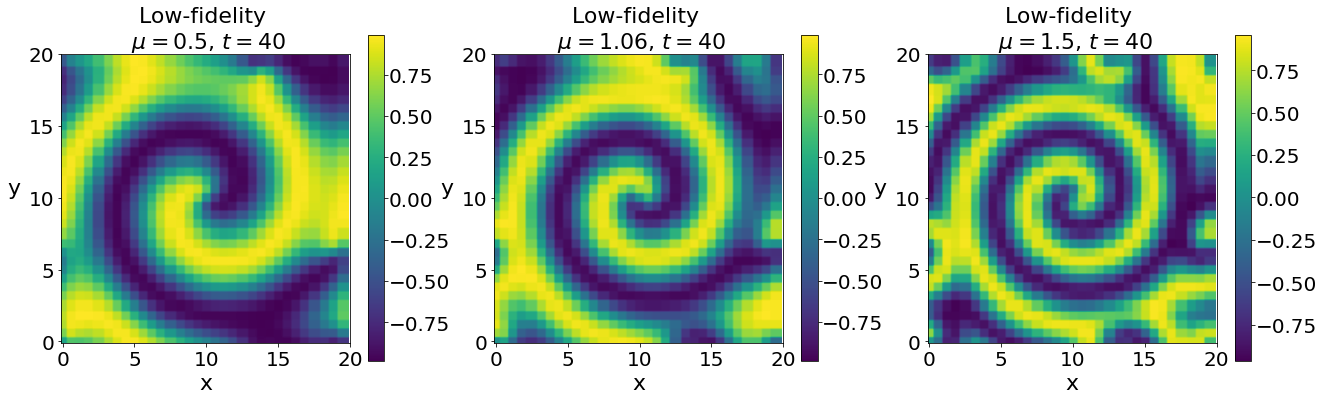

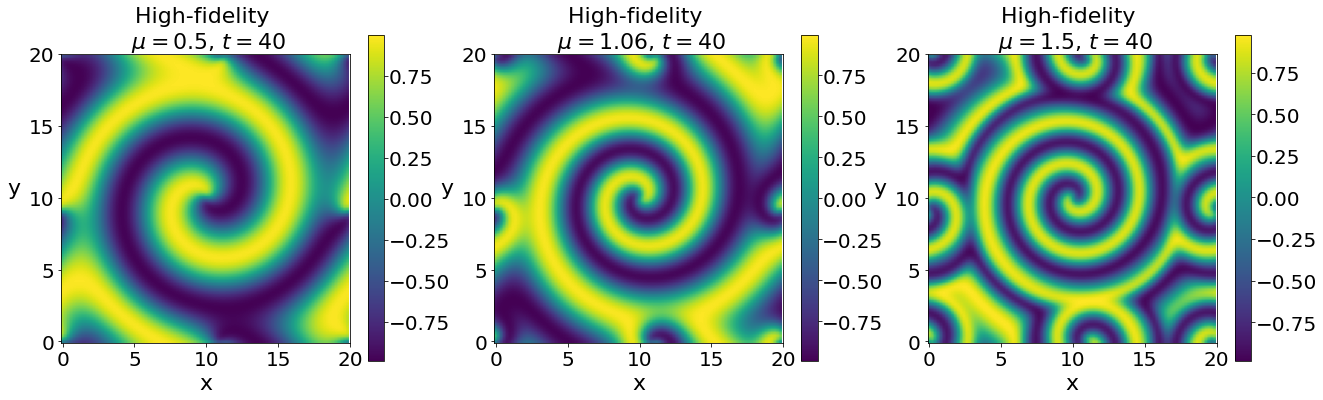

In [4]:
#########################   Visualize train data     ##########################
#########################         LF VS HF          ###########################

loc = np.arange(0,Nx_hf+1,int(Nx_hf/4))
tick = np.arange(0,21,5)

#Low-fidelity training data
fig = plt.figure(figsize=(22,6))
idx_mu_list = [0, int(N_mu_train/2), -1]
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_lf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc, tick,fontsize=20)
    plt.yticks(loc, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('Low-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_lf[-1])) , fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)
    
#High-fidelity training data
fig = plt.figure(figsize=(22,6))
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_hf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc, tick,fontsize=20)
    plt.yticks(loc, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('High-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_lf[-1])) , fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)

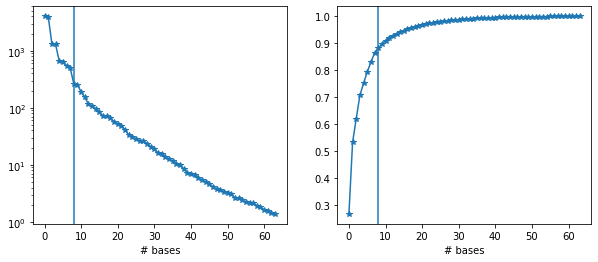

In [5]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################
n_POD_large = 64 # we consider first a larger basis

#Reshape for POD
u_hf_pod = np.reshape(u_hf, (N, Nt_train*N_mu_train), 'F')

#POD on HF training data
POM_u, S_u = compute_randomized_SVD(u_hf_pod, n_POD_large, N, 1)

#We restrict the POD basis to the first 9 POD modes
n_POD = 9

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(S_u,'*-')
plt.axvline(x = n_POD-1)
plt.yscale('log')
plt.xlabel('# bases')

plt.subplot(122)
plt.plot(np.cumsum(S_u)/np.sum(S_u),'*-')
plt.axvline(x = n_POD-1)
plt.xlabel('# bases')
plt.show()

POM_u = POM_u[:,:n_POD]
S_u = S_u[:n_POD]

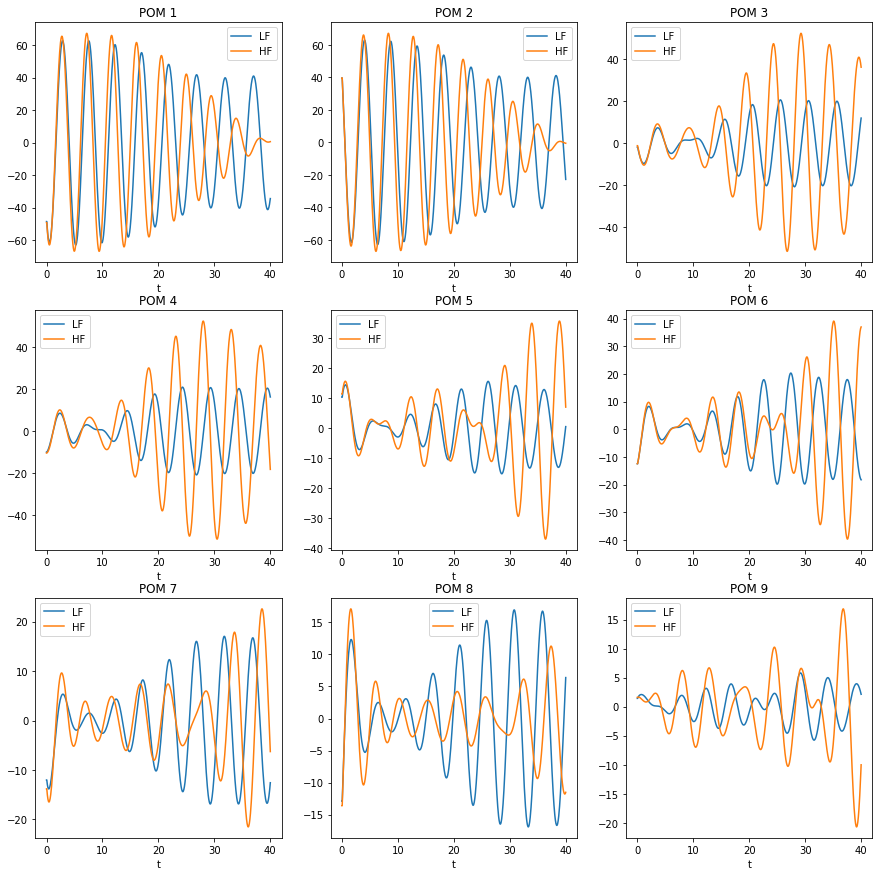

In [6]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_lf_pod = np.reshape(u_lf, (N, Nt_train*N_mu_train), 'F')
u_lf_test_pod = np.reshape(u_lf_test, (N, Nt_lf_test*N_mu_test), 'F')
u_hf_test_pod = np.reshape(u_hf_test, (N, Nt_test*N_mu_test), 'F')

ulf_train = u_lf_pod.T @ POM_u
uhf_train = u_hf_pod.T @ POM_u
ulf_test = u_lf_test_pod.T @ POM_u
uhf_test = u_hf_test_pod.T @ POM_u

#Reshape to make data suitable to LSTM network
ulf_train = np.reshape(ulf_train, (N_mu_train, Nt_train, -1))
uhf_train = np.reshape(uhf_train, (N_mu_train, Nt_train, -1))
ulf_test = np.reshape(ulf_test, (N_mu_test, Nt_lf_test, -1))
uhf_test = np.reshape(uhf_test, (N_mu_test, Nt_test, -1))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(331 + i)
    plt.plot(t_lf, ulf_train[-1,:,i], label = 'LF')
    plt.plot(t_hf, uhf_train[-1, :, i], label = 'HF')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

In [7]:
#########################   LSTM NN PREPROCESS    ##########################
#Scaling
if scaling:
    scale = np.max(ulf_train) 
    scale_param = 1.
else:
    scale =  1.
    scale_param = 1.
    
#train
t_train_lstm = np.tile(t_lf, N_mu_train).T.reshape(N_mu_train,-1,1)
mu_train_lstm = np.repeat(mu_train, Nt_train).reshape(N_mu_train,-1,1) / scale_param
ulf_train_lstm = ulf_train / scale
uhf_train_lstm = uhf_train / scale

#test
t_test_lstm = np.tile(t_hf_test, N_mu_test).T.reshape(N_mu_test,-1,1)
mu_test_lstm = np.repeat(mu_test, Nt_test).reshape(N_mu_test,-1,1) / scale_param
ulf_test_lstm = ulf_test / scale
uhf_test_lstm = uhf_test / scale

#Multi-fidelity network input
#concatenate in a single input: (time, param, LF data)
train_mf_lstm = np.concatenate((t_train_lstm, mu_train_lstm, ulf_train_lstm), axis=2)
test_mf_lstm = np.concatenate((t_test_lstm, mu_test_lstm, ulf_test_lstm), axis=2)

In [8]:
#########################   LSTM NN HYPERPARAMETERS    ##########################
params_MF = {'batch': 37, 
             'lay': 1, 
             'nodes': 69, 
             'lr':  0.009476420915650432, 
             'lay_dense': 0, 
             'nodes_dense': 0, 
             'opti': 'Adamax', 
             'sequence_freq': 7, 
             'sequence_length': 133,
             'epochs':  3000, 
             'patience' : 200, 
             'dropout' : 0.3}

In [9]:
#########################   TRAINING/LOADING    ##########################
if train:
    sequence_length = int(params_MF['sequence_length'])
    sequence_freq = int(params_MF['sequence_freq'])
    train_mf_lstm_seq, uhf_mf_train_seq = sliding_windows(train_mf_lstm, uhf_train_lstm, sequence_length, sequence_freq)

    model_MF = create_model(params = params_MF, input_dim = n_POD + 2, output_dim = n_POD) #(time, param, LF POD modes) == (1, 1, n_POD) -> n_POD+2
    
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
    hist_MF = train_model(params_MF, model_MF, train_mf_lstm_seq, uhf_mf_train_seq, verbose=1)
else:
    name = './results/models/model_RD'
    if scaling:
        name = name + '_scaled'
    model_MF = load_model(name)
    
if save:
    name = './results/models/model_RD_new'
    if scaling:
        name = name + '_scaled'
    save_model(model_MF, name)

Loaded ./results/models/model_RD_scaled


In [10]:
#########################   PREDICTION    ##########################
uMF_LSTM_train = model_MF.predict(train_mf_lstm).reshape(N_mu_train, Nt_train, -1) * scale
uMF_LSTM_test = model_MF.predict(test_mf_lstm).reshape(N_mu_test, Nt_test, -1) * scale

1/1 [==============================] - 2s 2s/step


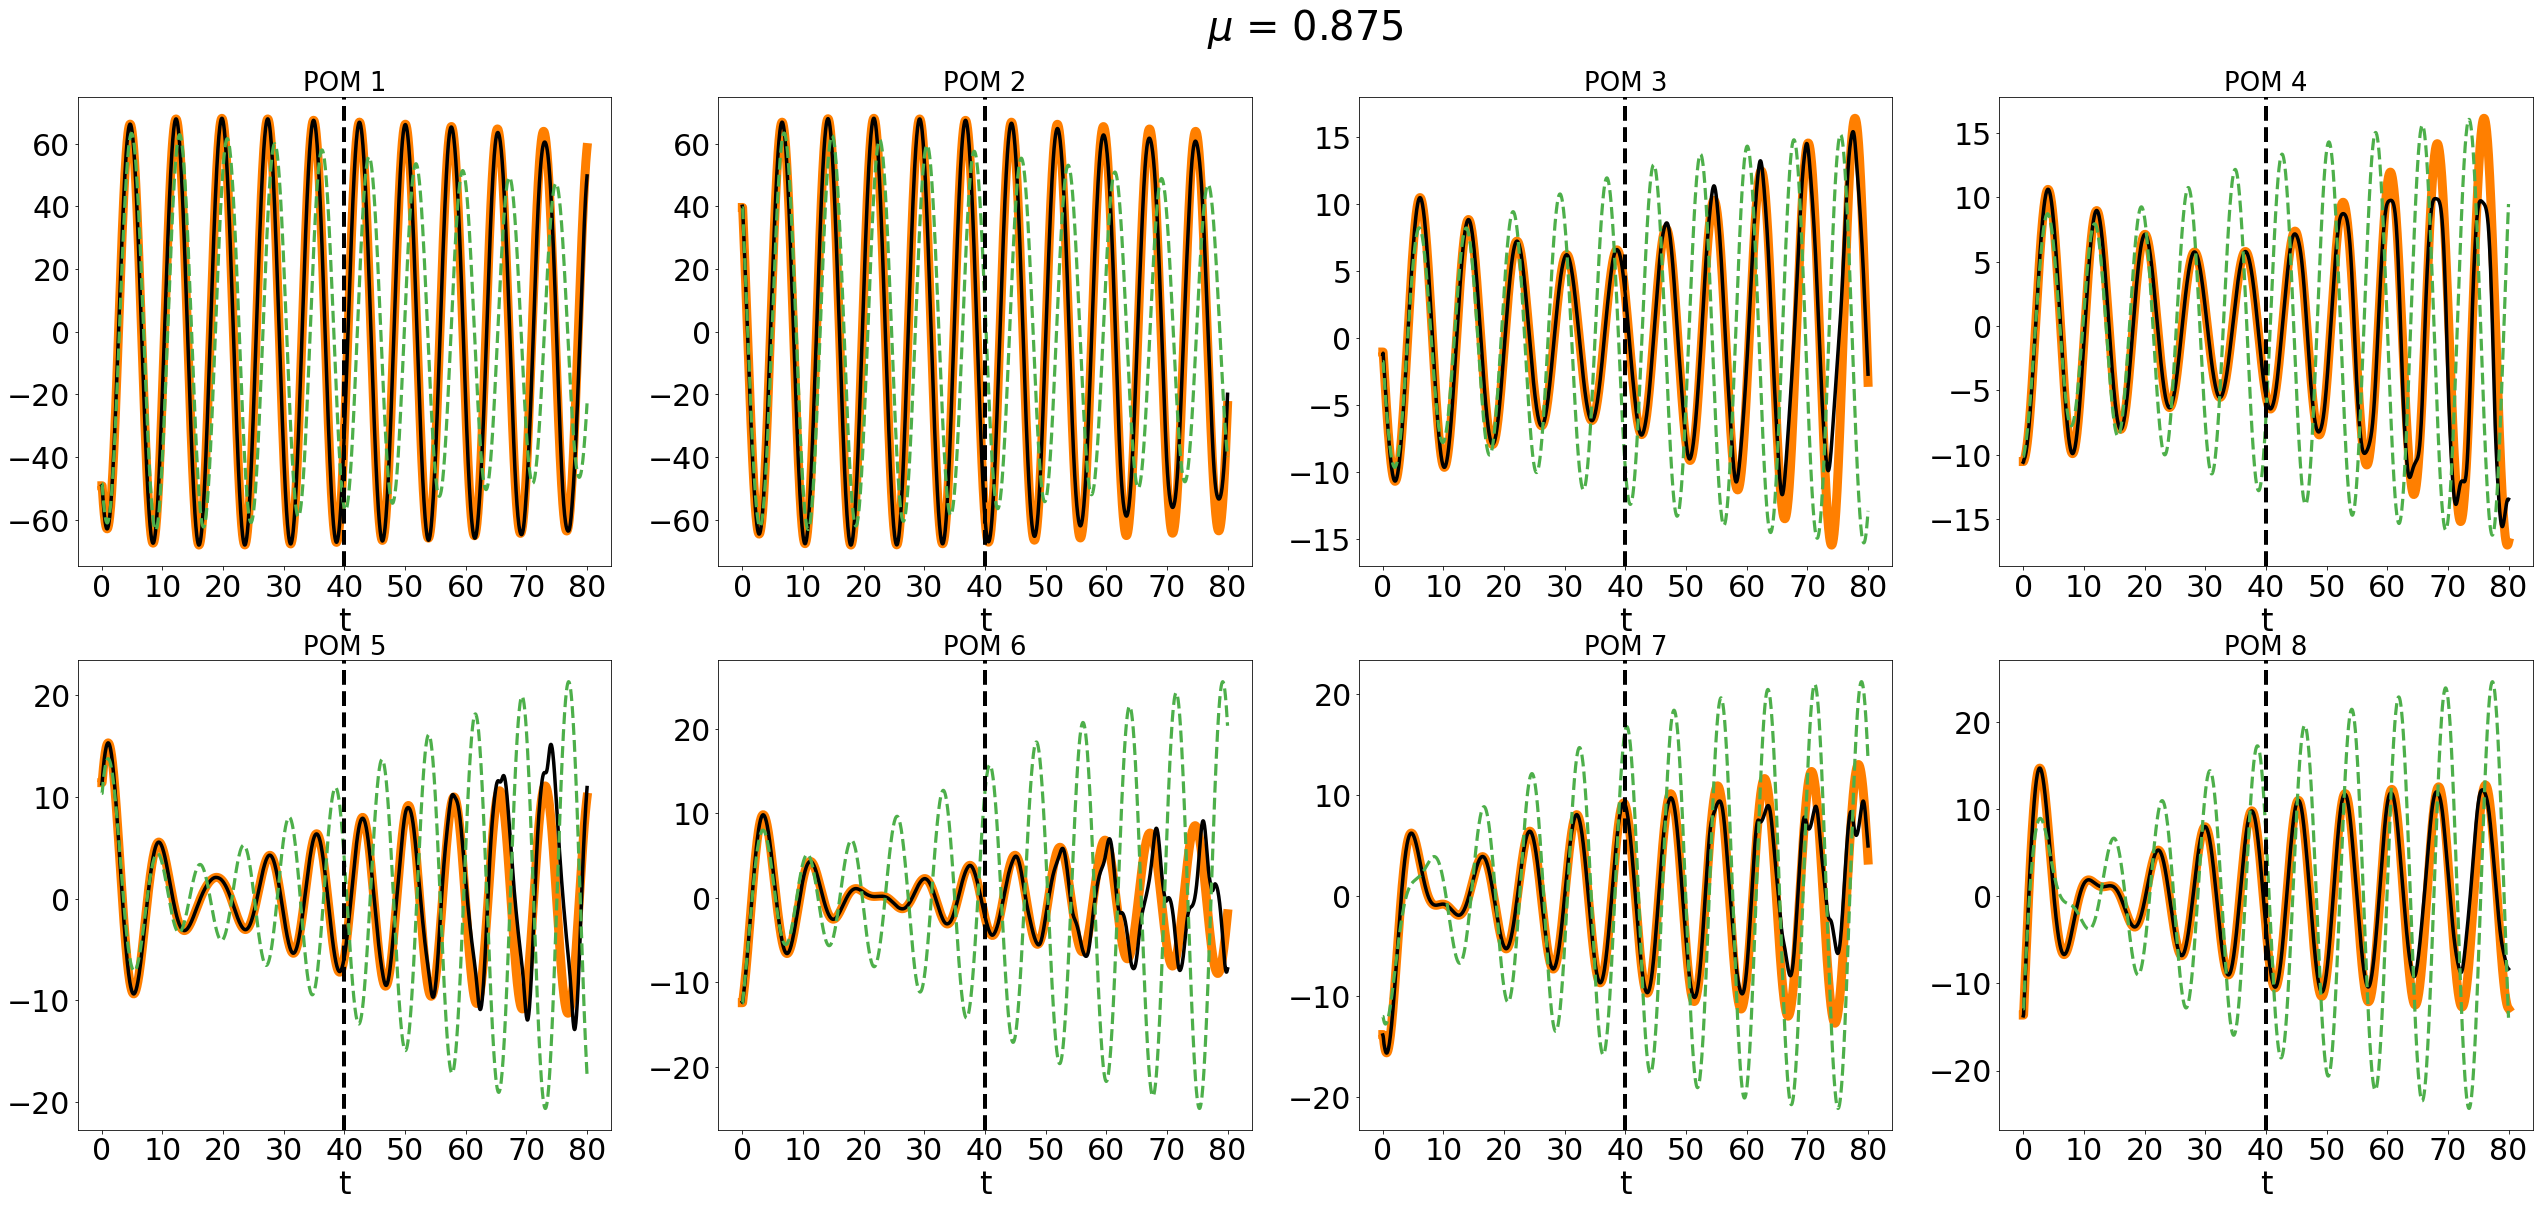

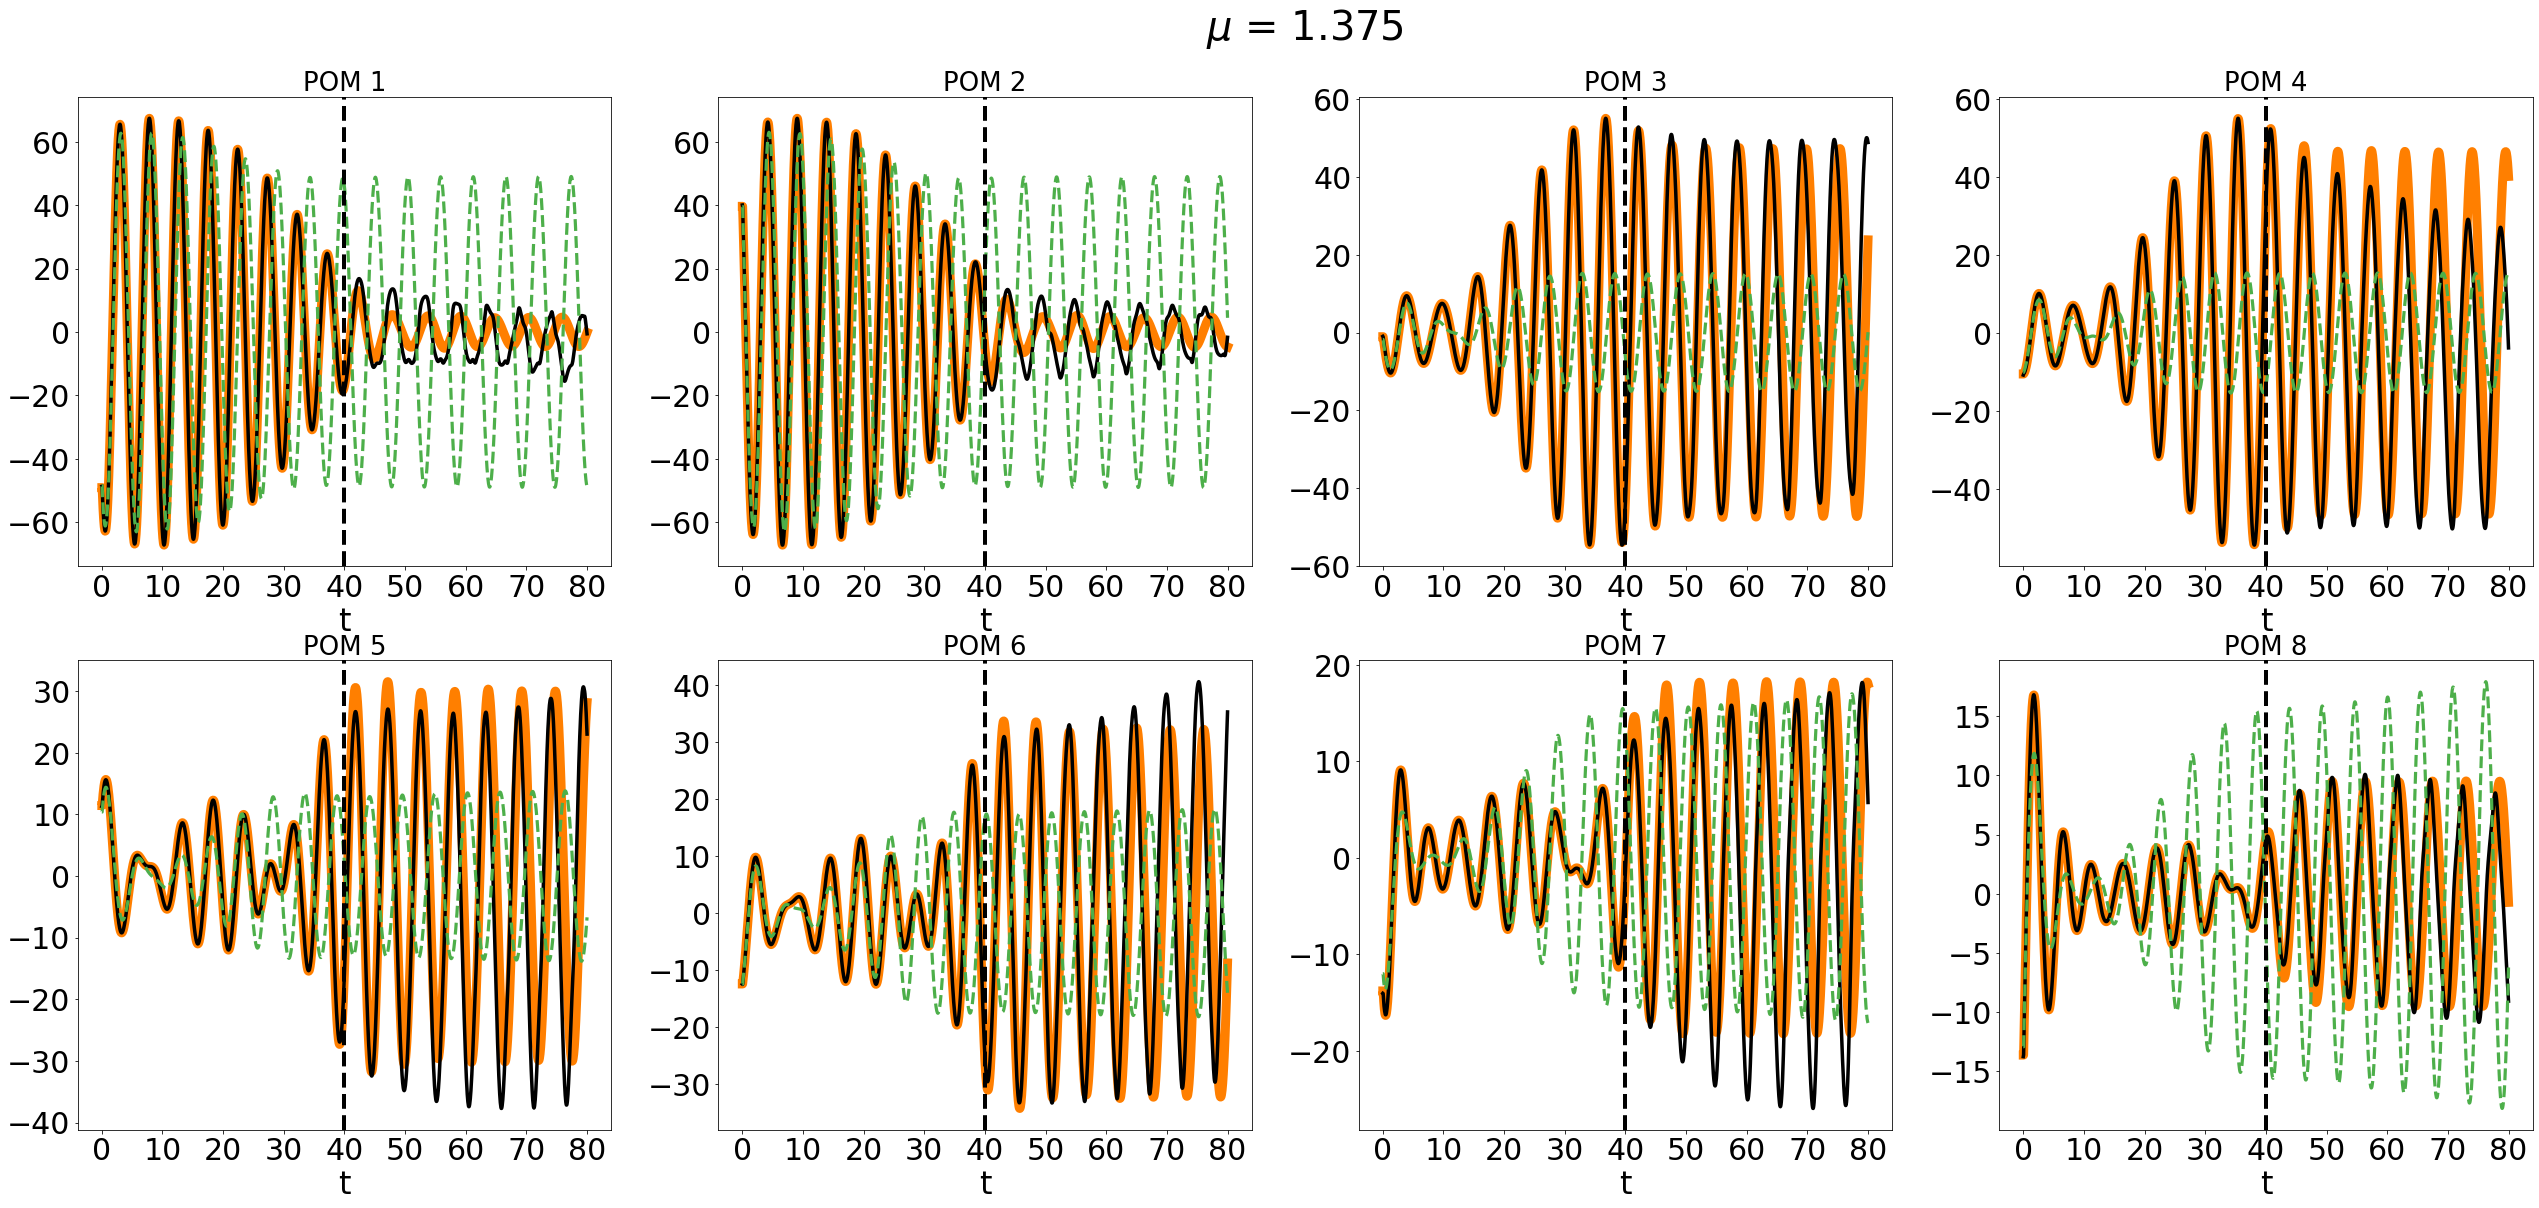

In [11]:
#########################   COMPARISON OF POD MODES    ##########################
if small_data:
    mus = [0,1]
else:
    mus = [9,21]
    
for mu in mus: 
    fig = plt.figure(figsize=(44,19)) 
    plt.title('$\mu$ = ' + str(mu_test[mu].round(3)) + '\n', fontsize = 40)
    plt.axis('off')
    for POD_mode in range(8):
        ax = fig.add_subplot(241 + POD_mode)

        plt.plot(t_hf_test, uhf_test[mu, :, POD_mode],'-', color = '#ff7f00', label = 'HF', linewidth = 9)
        plt.plot(t_hf_test, uMF_LSTM_test[mu, :, POD_mode],'k-', label = 'MF', linewidth = 3.5)
        plt.plot(t_hf_test, ulf_test[mu, :, POD_mode], '--', label = 'LF', color='#4daf4a', linewidth=3.2)

        plt.axvline(x=Thf, linestyle='--', color='black', linewidth = 4)
        ax.set_title('POM ' + str(POD_mode + 1), fontsize = 26)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('t', rotation=0, fontsize=32)
        #plt.legend(loc = 'lower right', fontsize = 24)
    plt.show()

In [12]:
#########################  POD RECONSTRUCTION    ##########################
uMF_LSTM_train_rec = (uMF_LSTM_train @ POM_u.T).reshape(N_mu_train, Nt_train, Nx_hf, Ny_hf).T
uMF_LSTM_test_rec = (uMF_LSTM_test @ POM_u.T).reshape(N_mu_test, Nt_test, Nx_hf, Ny_hf).T

abs_err_test = np.abs(uMF_LSTM_test_rec - u_hf_test)

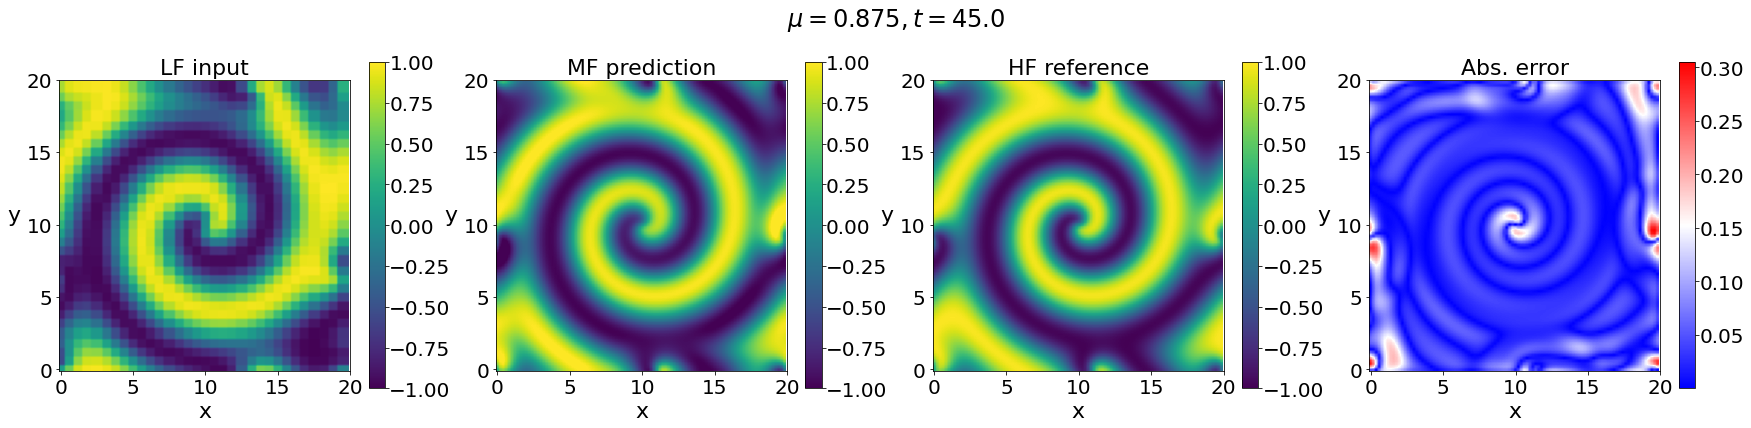

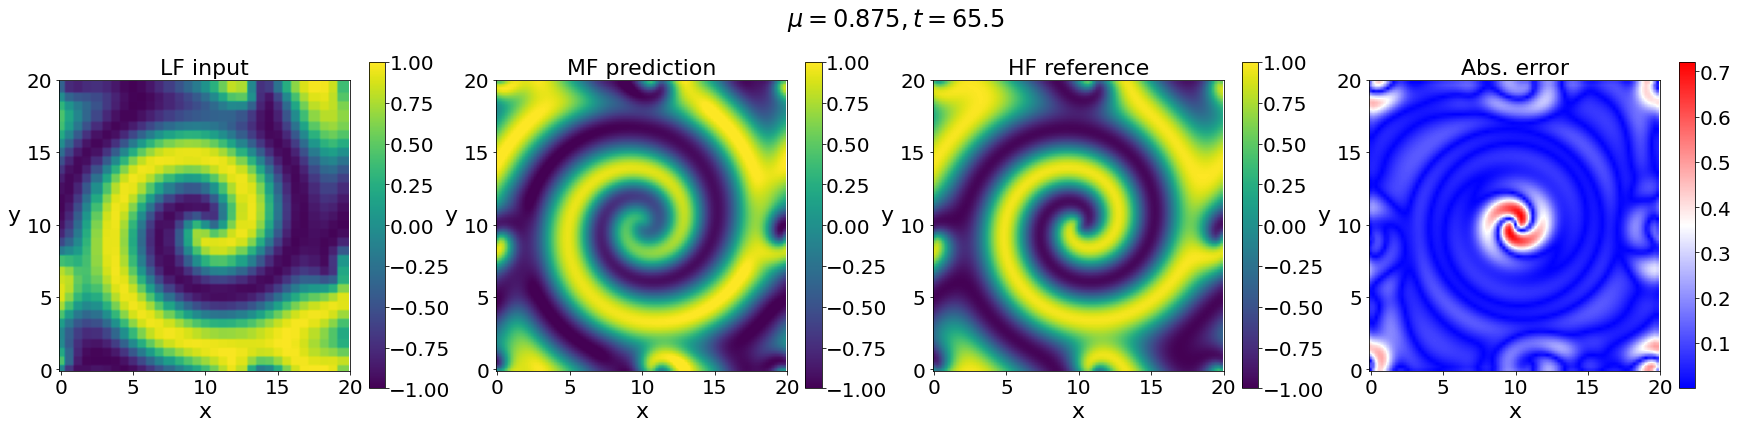

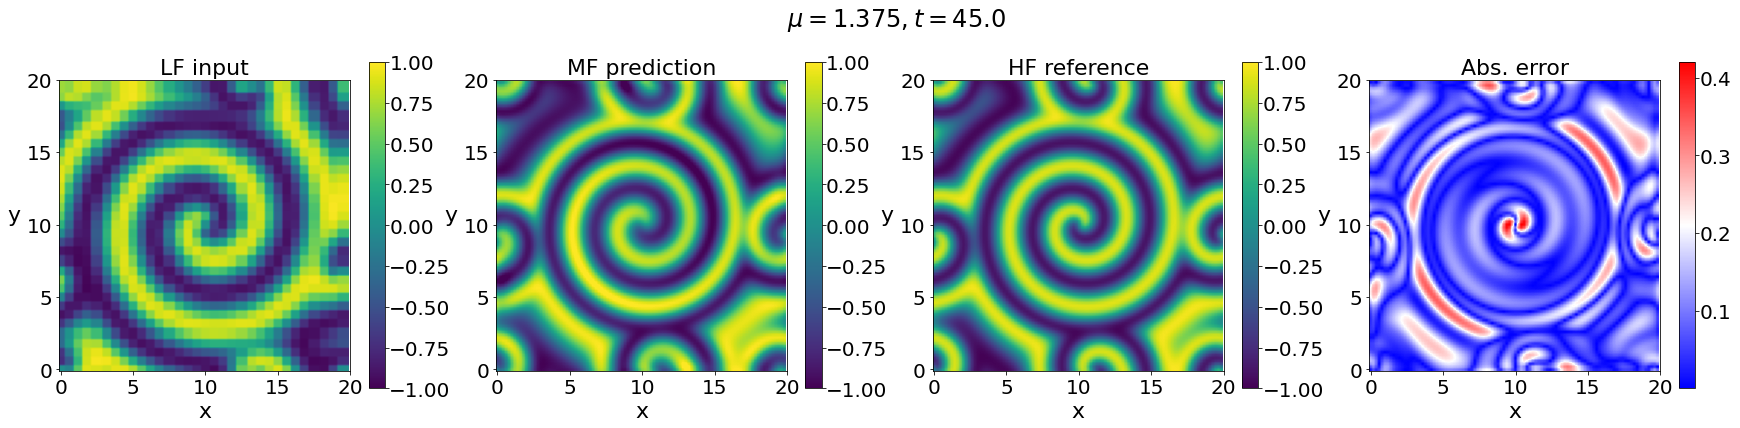

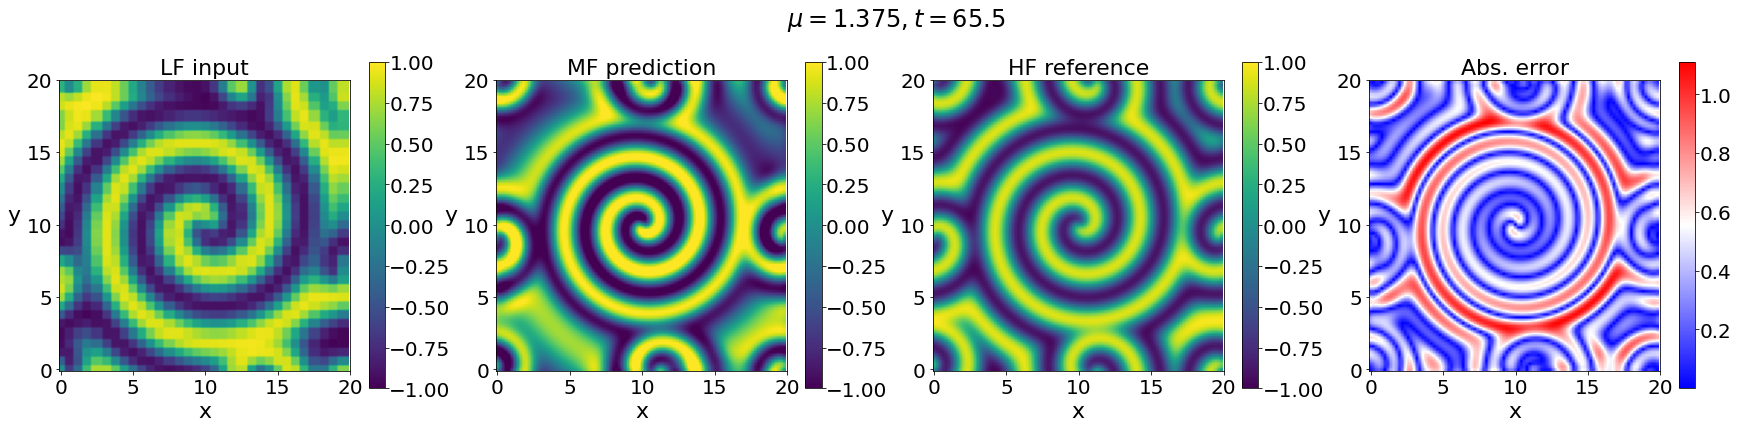

In [13]:
#########################   COMPARISON OF SOLUTION FIELDS     ##########################

if small_data:
    mus = [0,1]
else:
    mus = [9, 21]
times = [45, 65.5]

for mu in mus:
    for time in times:
        fig = plt.figure(figsize=(30,6))
        t = int(time/dt)
        plt.title('$\mu = $' + str(round(mu_test[mu],3)) + '$, t = $' + str(round(t*dt,1)) +'\n' , fontsize = 24)
        plt.axis('off')

        ax = fig.add_subplot(141)
        surf = ax.imshow(u_lf_test[:,:,t,mu], origin = 'lower', vmin=-1, vmax=1)
        plt.xticks(loc, tick,fontsize=20)
        plt.yticks(loc, tick,fontsize=20)
        plt.xlabel('x', rotation = 0,fontsize = 22)
        plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=13)
        title = 'LF input'
        ax.set_title(title, fontsize = 22)
        cbar = plt.colorbar(surf)
        cbar.ax.tick_params(labelsize=20,pad=1)
        
        ax = fig.add_subplot(142)
        surf = ax.imshow(uMF_LSTM_test_rec[:,:,t,mu], origin = 'lower', vmin=-1, vmax=1.)
        plt.xticks(loc, tick,fontsize=20)
        plt.yticks(loc, tick,fontsize=20)
        plt.xlabel('x', rotation = 0,fontsize = 22)
        plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=13)
        title = 'MF prediction' 
        ax.set_title(title, fontsize = 22)
        cbar = plt.colorbar(surf)
        cbar.ax.tick_params(labelsize=20,pad=1)

        ax = fig.add_subplot(143)
        surf = ax.imshow(u_hf_test[:,:,t,mu], origin = 'lower', vmin=-1, vmax=1.)
        plt.xticks(loc, tick,fontsize=20)
        plt.yticks(loc, tick,fontsize=20)
        plt.xlabel('x', rotation = 0,fontsize = 22)
        plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=13)
        title = 'HF reference'  
        ax.set_title(title, fontsize = 22)
        cbar = plt.colorbar(surf)
        cbar.ax.tick_params(labelsize=20,pad=1)
        
        ax = fig.add_subplot(144)
        surf = ax.imshow(abs_err_test[:,:,t,mu], origin = 'lower', cmap='bwr')
        plt.xticks(loc, tick,fontsize=20)
        plt.yticks(loc, tick,fontsize=20)
        plt.xlabel('x', rotation = 0,fontsize = 22)
        plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=13)
        title = 'Abs. error' 
        ax.set_title(title, fontsize = 22)
        cbar = plt.colorbar(surf)
        cbar.ax.tick_params(labelsize=20,pad=1)
        plt.show()

In [ ]:
#########################   CREATE VIDEO    ##########################
from celluloid import Camera
from matplotlib.animation import PillowWriter
from IPython.display import HTML

fig, ax = plt.subplots(1, 4, figsize=(16, 4.5))

camera = Camera(fig)
mu = mus[0]
for i in range(0, 1600, 5):
    surf = ax[0].imshow(u_lf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[1].imshow(uMF_LSTM_test_rec[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[2].imshow(u_hf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[3].imshow(np.abs(uMF_LSTM_test_rec[:, :, i, mu] - u_hf_test[:, :, i, mu]),cmap='bwr')
    
    ax[0].set_title("LF input", fontsize = 20)
    ax[1].set_title("MF-POD pred.", fontsize = 20)
    ax[2].set_title("HF reference", fontsize = 20)
    ax[3].set_title("Abs. error", fontsize = 20)
    
    camera.snap()
fig.suptitle("$\mu$ = " + str(round(mu_test[mu],3)), fontsize = 22)
animation = camera.animate()

# Close the figure to prevent it from being displayed
plt.close(fig)

# Save the animation as a GIF using PillowWriter
name = "./results/test_HF_" + str(round(mu_test[mu],3)) + ".gif"
animation.save(name, writer=PillowWriter(fps=10))

# Display the saved GIF
HTML("<img src='" + name + "'>")

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4.5))

camera = Camera(fig)
mu = mus[1]
for i in range(0, 1600, 5):
    surf = ax[0].imshow(u_lf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[1].imshow(uMF_LSTM_test_rec[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[2].imshow(u_hf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[3].imshow(np.abs(uMF_LSTM_test_rec[:, :, i, mu] - u_hf_test[:, :, i, mu]), cmap='bwr')
    
    ax[0].set_title("LF input", fontsize = 20)
    ax[1].set_title("MF-POD pred.", fontsize = 20)
    ax[2].set_title("HF reference", fontsize = 20)
    ax[3].set_title("Abs. error", fontsize = 20)
    
    
    camera.snap()
fig.suptitle("$\mu$ = " + str(round(mu_test[mu],3)), fontsize = 22)
animation = camera.animate()

# Close the figure to prevent it from being displayed
plt.close(fig)

# Save the animation as a GIF using PillowWriter
name = "./results/test_HF_" + str(round(mu_test[mu],3)) + ".gif"
animation.save(name, writer=PillowWriter(fps=10))


# Display the saved GIF
HTML("<img src='" + name + "'>")